In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import joblib
import xgboost as xgb
import warnings 
warnings.filterwarnings("ignore")


import os
import random
import tensorflow as tf

# 1. Set Python seed
random.seed(42)

# 2. Set NumPy seed
np.random.seed(42)

# 3. Set TensorFlow seed
tf.random.set_seed(42)

In [3]:
# features = ['Open', 'High', 'Low', 'Close', 'Volume', 'Daily_Return', 'MA5', 'MA10', 'Volatility']
features = ['Open', 'High', 'Low', 'Close','MA10', 'Target']

In [4]:
train_df = pd.read_csv(r'D:\Cloudly IO\Tesla-Forcasting-Project\data\preprocessed\Tasla_Stock_Updated_train.csv')[features]
test_df = pd.read_csv(r'D:\Cloudly IO\Tesla-Forcasting-Project\data\preprocessed\Tasla_Stock_Updated_test.csv')[features]

train_data = train_df
test_data = test_df

In [5]:
train_df.head()

,Open,High,Low,Close,MA10,Target
0,12.966000,13.050000,12.666667,12.791333,13.732867,12.871333
1,12.713333,12.966000,12.643333,12.871333,13.557933,12.795333
2,12.924667,12.941333,12.469333,12.795333,13.436866,13.104667
3,12.636667,13.245333,12.634000,13.104667,13.338800,13.441333
4,13.133333,13.549333,13.013333,13.441333,13.276600,13.419333


In [6]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Separate features and target
X_train = train_data.drop(['Target'], axis=1)
y_train = train_data['Target']

X_test = test_data.drop(['Target'], axis=1)
y_test = test_data['Target']

# Scale features
scaler_X = StandardScaler()
X_train_scaled = pd.DataFrame(scaler_X.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler_X.transform(X_test), columns=X_test.columns, index=X_test.index)

# Scale target
scaler_y = StandardScaler()
y_train_scaled = pd.DataFrame(scaler_y.fit_transform(y_train.values.reshape(-1, 1)), columns=['Target'], index=y_train.index)
y_test_scaled = pd.DataFrame(scaler_y.transform(y_test.values.reshape(-1, 1)), columns=['Target'], index=y_test.index)


In [7]:
y_train_scaled

,Target
0,-0.599204
1,-0.599979
2,-0.596825
3,-0.593391
4,-0.593616
...,...
1804,2.232446
1805,2.347312
1806,2.400920
1807,2.648464


# Model evaluation

In [8]:
def loss_curve(history):
  # 1. Access loss values
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  # 2. Plot it
  plt.figure(figsize=(10, 6))
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.title('Neural Network Loss Curve')
  plt.xlabel('Epochs')
  plt.ylabel('MSE Loss')
  plt.legend()
  plt.grid(True)
  plt.tight_layout()
  plt.show()

In [9]:
def evaluate_model(model, X_test, y_test):
  # Evaluation Metrics
  y_pred = model.predict(X_test)
  mae = mean_absolute_error(y_test, y_pred)
  rmse = np.sqrt(mean_squared_error(y_test, y_pred))
  r2 = r2_score(y_test, y_pred)

  print(f"MAE: {mae:.2f}")
  print(f"RMSE: {rmse:.2f}")
  print(f"R² Score: {r2:.2f}")

  # Visual Comparison
  plt.figure(figsize=(20,5))
  plt.plot(y_test.values, label='Actual')
  plt.plot(y_pred, label='Predicted')
  plt.title("Actual vs Predicted Tesla Monthly Closing Price")
  plt.legend()
  plt.show()


# XGBoost

In [21]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Train the model
model_xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
model_xgb.fit(X_train_scaled, y_train_scaled)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

MAE: 0.08
RMSE: 0.11
R² Score: 0.95


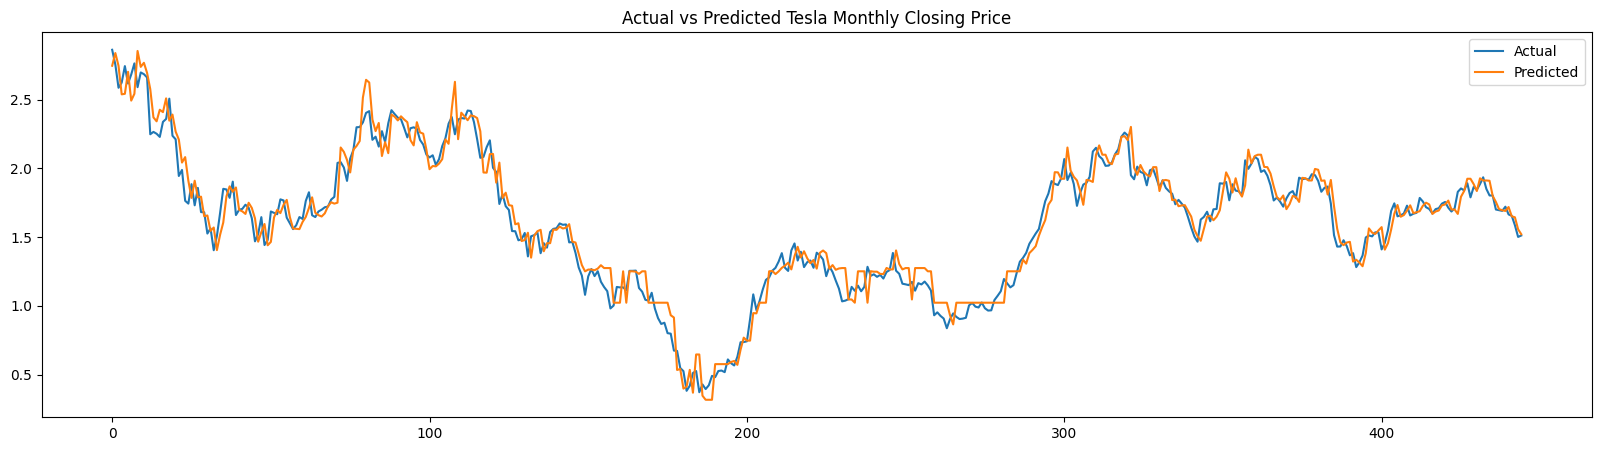

In [22]:
evaluate_model(model_xgb, X_test_scaled, y_test_scaled)

In [24]:
joblib.dump(model_xgb, r'D:\Cloudly IO\Tesla-Forcasting-Project\notebook\saved_models\model_xgb.pkl') #Save model

['D:\\Cloudly IO\\Tesla-Forcasting-Project\\notebook\\saved_models\\model_xgb.pkl']

# Linear regression

In [25]:
from sklearn.linear_model import LinearRegression

model_lnr = LinearRegression()
model_lnr.fit(X_train_scaled, y_train_scaled)


LinearRegression()

MAE: 0.06
RMSE: 0.09
R² Score: 0.97


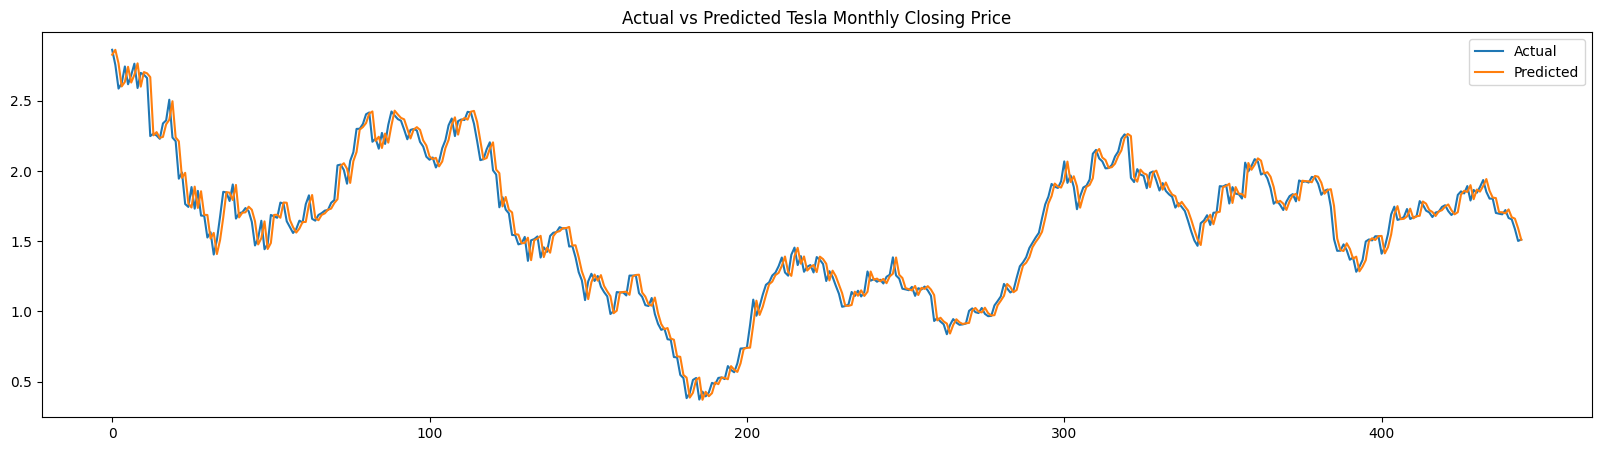

In [26]:
evaluate_model(model_lnr, X_test_scaled, y_test_scaled)

In [27]:
joblib.dump(model_lnr, r'D:\Cloudly IO\Tesla-Forcasting-Project\notebook\saved_models\model_lnr.pkl') #Save model

['D:\\Cloudly IO\\Tesla-Forcasting-Project\\notebook\\saved_models\\model_lnr.pkl']

# Neural Nerwork

In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from tensorflow.keras.optimizers import Adam


# 2. Define the model
model_nn = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dropout(0.1),
    Dense(1)  # Output: next month's closing price
])

# 3. Compile
model_nn.compile(
    optimizer=Adam(0.001),
    loss='mse',  # regression problem
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

# 4. Train with early stopping
# early_stop = EarlyStopping(patience=10, restore_best_weights=True)

history_nn = model_nn.fit(
    X_train_scaled, y_train_scaled,
    validation_split=0.2,
    epochs=40,
    batch_size=16,
    # callbacks=[early_stop],
    verbose=1
)

Epoch 1/40
91/91 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.1630 - root_mean_squared_error: 0.3936 - val_loss: 0.0265 - val_root_mean_squared_error: 0.1629
Epoch 2/40
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0209 - root_mean_squared_error: 0.1443 - val_loss: 0.0731 - val_root_mean_squared_error: 0.2703
Epoch 3/40
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0179 - root_mean_squared_error: 0.1338 - val_loss: 0.0227 - val_root_mean_squared_error: 0.1507
Epoch 4/40
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0137 - root_mean_squared_error: 0.1170 - val_loss: 0.1480 - val_root_mean_squared_error: 0.3847
Epoch 5/40
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0104 - root_mean_squared_error: 0.1019 - val_loss: 0.0129 - val_root_mean_squared_error: 0.1138
Epoch 6/40
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0089 - root_mean_squared_error: 0.0942 - val_loss: 0.1815 - val_root_mean_squared_error: 0.4260
Epoch 7/40
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss:

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
MAE: 0.22
RMSE: 0.24
R² Score: 0.77


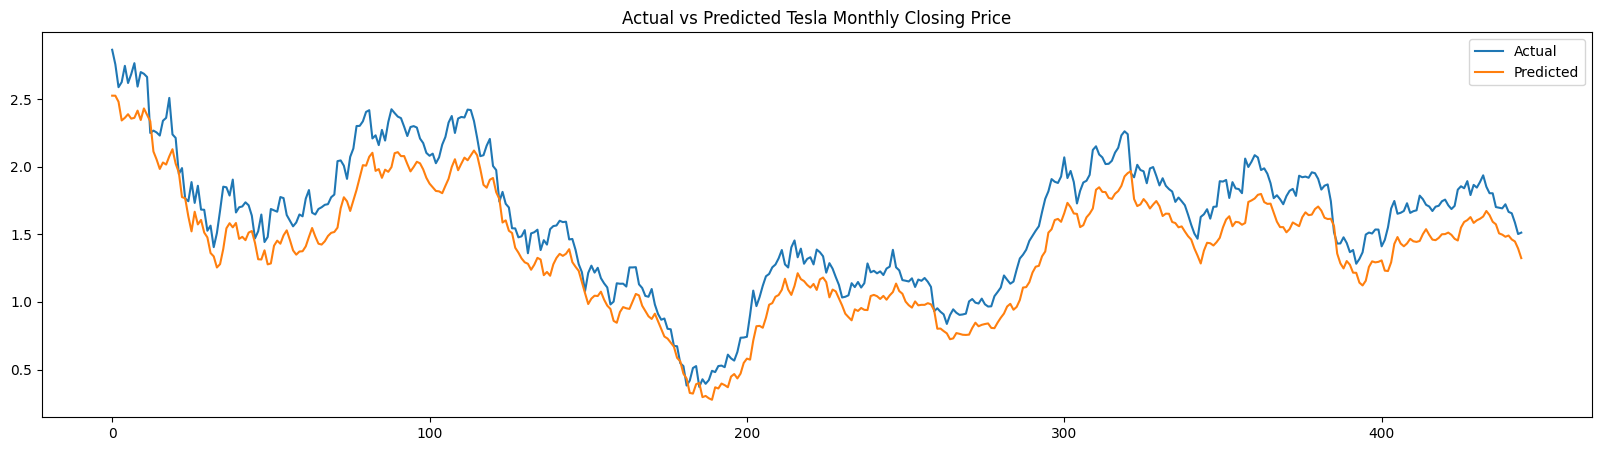

In [13]:
evaluate_model(model_nn, X_test_scaled, y_test_scaled)

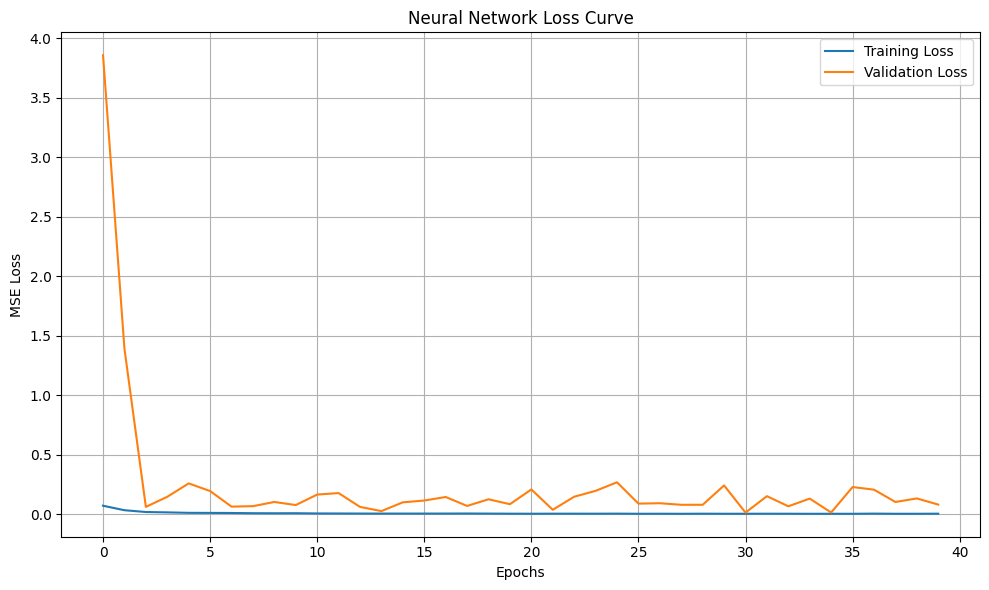

In [36]:
loss_curve(history_nn)

In [37]:
joblib.dump(model_nn, r'D:\Cloudly IO\Tesla-Forcasting-Project\notebook\saved_models\model_nn.pkl') #Save model

['D:\\Cloudly IO\\Tesla-Forcasting-Project\\notebook\\saved_models\\model_nn.pkl']

# RNN Based Models

In [14]:
def framing(data: pd.DataFrame, target: pd.Series, window_size: int):
    X, y = [], []

    for i in range(len(data) - window_size):
        X.append(data.iloc[i:(i + window_size)].values)  # use .values for consistency
        y.append(target.iloc[i + window_size])  # safer than target[i + window_size]

    X = np.array(X)
    y = pd.DataFrame(y, columns=['Target'])

    return X, y


In [15]:
train_df_aug = pd.concat([train_df, train_df.tail(501), train_df.tail(300)])[features]
train_df_aug


,Open,High,Low,Close,MA10,Target
0,12.966000,13.050000,12.666667,12.791333,13.732867,12.871333
1,12.713333,12.966000,12.643333,12.871333,13.557933,12.795333
2,12.924667,12.941333,12.469333,12.795333,13.436866,13.104667
3,12.636667,13.245333,12.634000,13.104667,13.338800,13.441333
4,13.133333,13.549333,13.013333,13.441333,13.276600,13.419333
...,...,...,...,...,...,...
1804,269.666656,280.666656,267.420013,280.076660,273.588995,290.533325
1805,276.996674,291.666656,275.239990,290.533325,274.665994,301.796661
1806,291.496674,302.616669,289.130005,301.796661,276.902661,307.053345
1807,304.993347,314.283325,302.363342,307.053345,280.788663,331.326660


In [16]:
#Features and Target Seperation of Train Data
X_train_RNN = train_df_aug.drop(['Target'], axis=1)
y_train_RNN = train_df_aug['Target']

X_test_RNN = test_df[features].drop(['Target'], axis=1)
y_test_RNN = test_df['Target']

##Testing purpose

# Scale features
scaler_X = StandardScaler()
X_train_RNN = pd.DataFrame(scaler_X.fit_transform(X_train_RNN), columns=X_train_RNN.columns, index=X_train_RNN.index)
X_test_RNN = pd.DataFrame(scaler_X.transform(X_test_RNN), columns=X_test_RNN.columns, index=X_test_RNN.index)

# Scale target
scaler_y = StandardScaler()
y_train_RNN = pd.DataFrame(scaler_y.fit_transform(y_train_RNN.values.reshape(-1, 1)), columns=['Target'], index=y_train_RNN.index)
y_test_RNN = pd.DataFrame(scaler_y.transform(y_test_RNN.values.reshape(-1, 1)), columns=['Target'], index=y_test_RNN.index)



In [17]:
X_train_RNN , y_train_RNN = framing(X_train_RNN, y_train_RNN, 5)
X_test_RNN , y_test_RNN = framing(X_test_RNN, y_test_RNN, 5)

In [18]:
X_train_RNN[0]

array([[-0.89812244, -0.89927201, -0.89915021, -0.90001687, -0.88879286],
       [-0.9002362 , -0.89995891, -0.89935051, -0.89934747, -0.89026483],
       [-0.89846822, -0.90016062, -0.90084418, -0.8999834 , -0.89128354],
       [-0.90087758, -0.89767469, -0.89943063, -0.89739505, -0.89210871],
       [-0.89672256, -0.89518876, -0.89617433, -0.894578  , -0.89263209]])

## LSTM

In [19]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from tensorflow.keras.optimizers import Adam


# 2. Define the LSTM model
model_lstm = Sequential([
    LSTM(50, activation='tanh', return_sequences=True, input_shape=(X_train_RNN.shape[1], X_train_RNN.shape[2])),
    LSTM(64, activation='tanh', return_sequences=False, input_shape=(X_train_RNN.shape[1], X_train_RNN.shape[2])),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dropout(0.1),
    Dense(32, activation='relu'),
    Dropout(0.1),
    Dense(16, activation='relu'),
    Dropout(0.1),
    Dense(1, activation= 'linear')
])

# 3. Compile
model_lstm.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

# 4. Train
early_stop = EarlyStopping(patience=10, restore_best_weights=True)

history_lstm = model_lstm.fit(
    X_train_RNN, y_train_RNN,
    validation_split=0.2,
    epochs=32,
    batch_size=8,
    # callbacks=[early_stop],
    verbose=1
)


Epoch 1/32
261/261 ━━━━━━━━━━━━━━━━━━━━ 25s 35ms/step - loss: 0.2675 - root_mean_squared_error: 0.4965 - val_loss: 0.0631 - val_root_mean_squared_error: 0.2512
Epoch 2/32
261/261 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.0679 - root_mean_squared_error: 0.2595 - val_loss: 0.0260 - val_root_mean_squared_error: 0.1611
Epoch 3/32
261/261 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.0514 - root_mean_squared_error: 0.2258 - val_loss: 0.0654 - val_root_mean_squared_error: 0.2558
Epoch 4/32
261/261 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0460 - root_mean_squared_error: 0.2137 - val_loss: 0.0602 - val_root_mean_squared_error: 0.2454
Epoch 5/32
261/261 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - loss: 0.0458 - root_mean_squared_error: 0.2132 - val_loss: 0.0906 - val_root_mean_squared_error: 0.3009
Epoch 6/32
261/261 ━━━━━━━━━━━━━━━━━━━━ 14s 51ms/step - loss: 0.0398 - root_mean_squared_error: 0.1983 - val_loss: 0.0334 - val_root_mean_squared_error: 0.1828
Epoch 7/32
261/261 ━━━━━━━━━━━━━━━━━━━━ 16s

14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step
MAE: 0.09
RMSE: 0.11
R² Score: 0.92


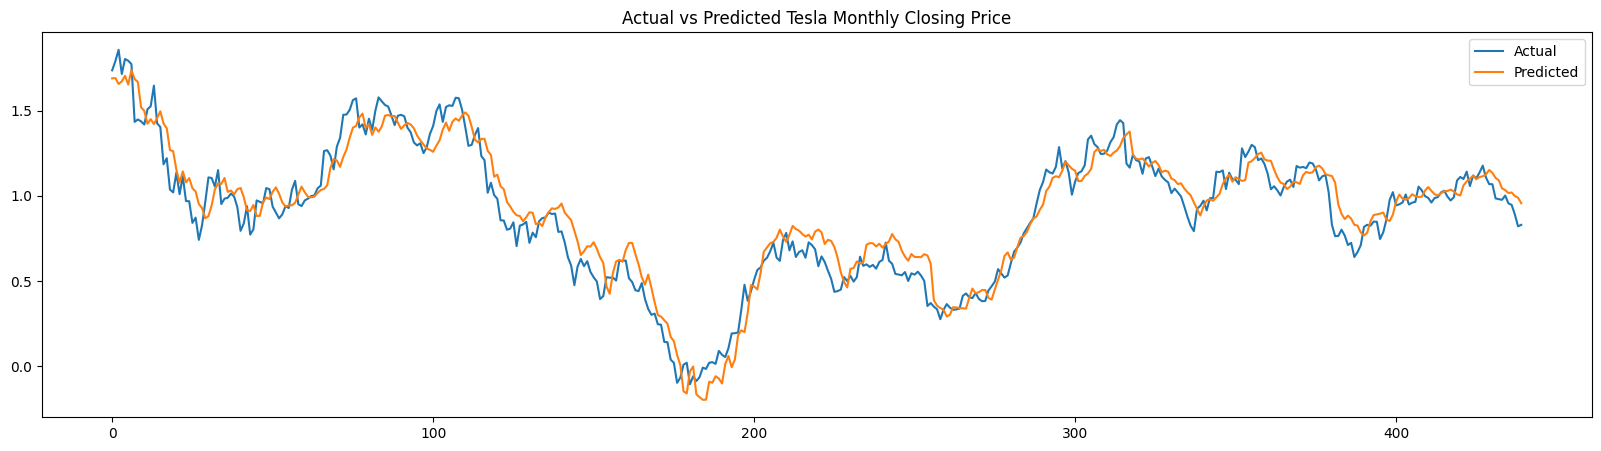

In [20]:
# evaluate_model(model_lstm, X_train_RNN, y_train_RNN)
evaluate_model(model_lstm, X_test_RNN, y_test_RNN)

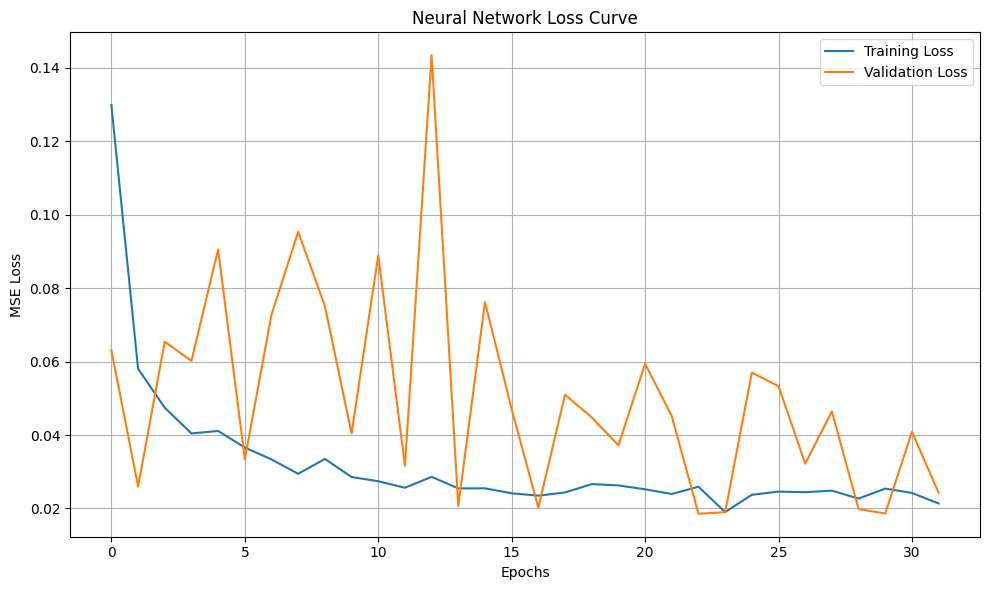

In [21]:
loss_curve(history_lstm)

In [29]:
import joblib
joblib.dump(model_lstm, r'D:\Cloudly IO\Tesla-Forcasting-Project\notebook\saved_models\model_lstm.pkl') #Save model

['D:\\Cloudly IO\\Tesla-Forcasting-Project\\notebook\\saved_models\\model_lstm.pkl']

## GRU

In [24]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, GRU
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay


# Define the GRU model
model_gru = Sequential([
    GRU(128, return_sequences=True, input_shape=(X_train_RNN.shape[1], X_train_RNN.shape[2])),
    Dropout(0.3),
    GRU(64, return_sequences=True),
    Dropout(0.2),
    GRU(64, return_sequences=False),
    Dense(64, activation='relu'),
    Dropout(0.2),
    # Dense(32, activation='relu'),
    # Dropout(0.1),
    Dense(1)
])

# 3. Compile

lr_schedule = ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=1000,
    decay_rate=0.9
)

optimizer = Adam(learning_rate=lr_schedule)

model_gru.compile(
    optimizer=optimizer,
    loss='mse',
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

# 4. Train
early_stop = EarlyStopping(patience=10, restore_best_weights=True)

history_gru = model_gru.fit(
    X_train_RNN, y_train_RNN,
    validation_split=0.2,
    epochs=64,
    batch_size=8,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/64
261/261 ━━━━━━━━━━━━━━━━━━━━ 32s 35ms/step - loss: 0.0936 - root_mean_squared_error: 0.2879 - val_loss: 0.0468 - val_root_mean_squared_error: 0.2164
Epoch 2/64
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - loss: 0.0315 - root_mean_squared_error: 0.1767 - val_loss: 0.0256 - val_root_mean_squared_error: 0.1600
Epoch 3/64
261/261 ━━━━━━━━━━━━━━━━━━━━ 14s 50ms/step - loss: 0.0300 - root_mean_squared_error: 0.1722 - val_loss: 0.0429 - val_root_mean_squared_error: 0.2071
Epoch 4/64
261/261 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - loss: 0.0259 - root_mean_squared_error: 0.1600 - val_loss: 0.0247 - val_root_mean_squared_error: 0.1571
Epoch 5/64
261/261 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0284 - root_mean_squared_error: 0.1674 - val_loss: 0.0278 - val_root_mean_squared_error: 0.1668
Epoch 6/64
261/261 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - loss: 0.0218 - root_mean_squared_error: 0.1466 - val_loss: 0.0207 - val_root_mean_squared_error: 0.1440
Epoch 7/64
261/261 ━━━━━━━━━━━━━━━━━━━━ 23

14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 208ms/step
MAE: 0.08
RMSE: 0.10
R² Score: 0.93


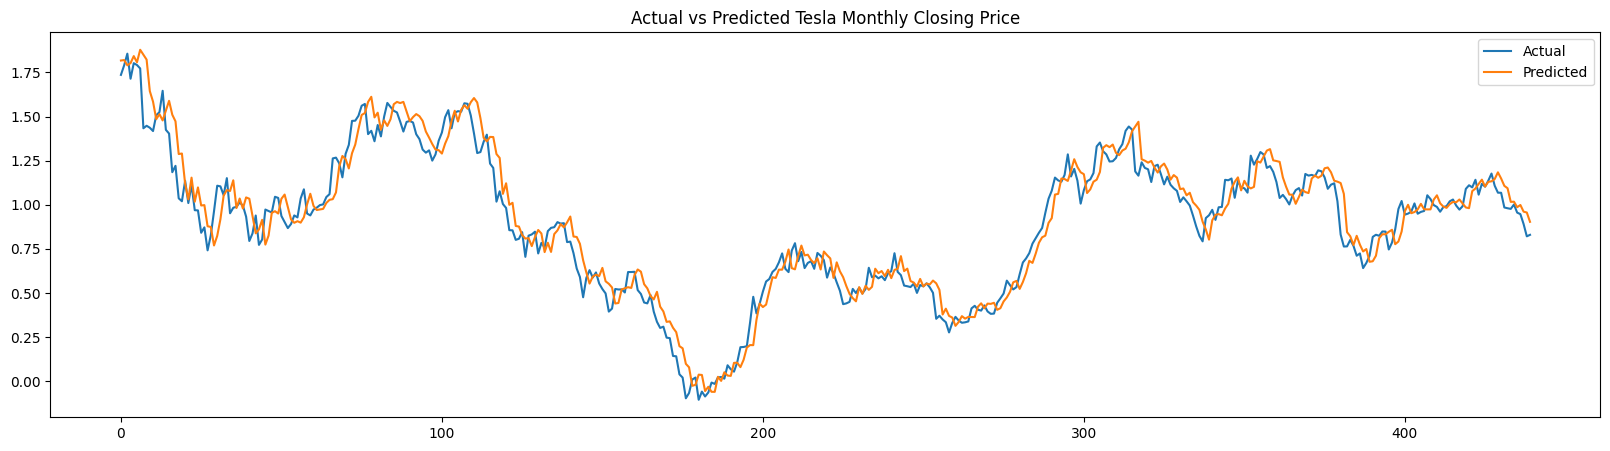

In [25]:
# evaluate_model(model_gru, X_train_RNN, y_train_RNN)
evaluate_model(model_gru, X_test_RNN, y_test_RNN)

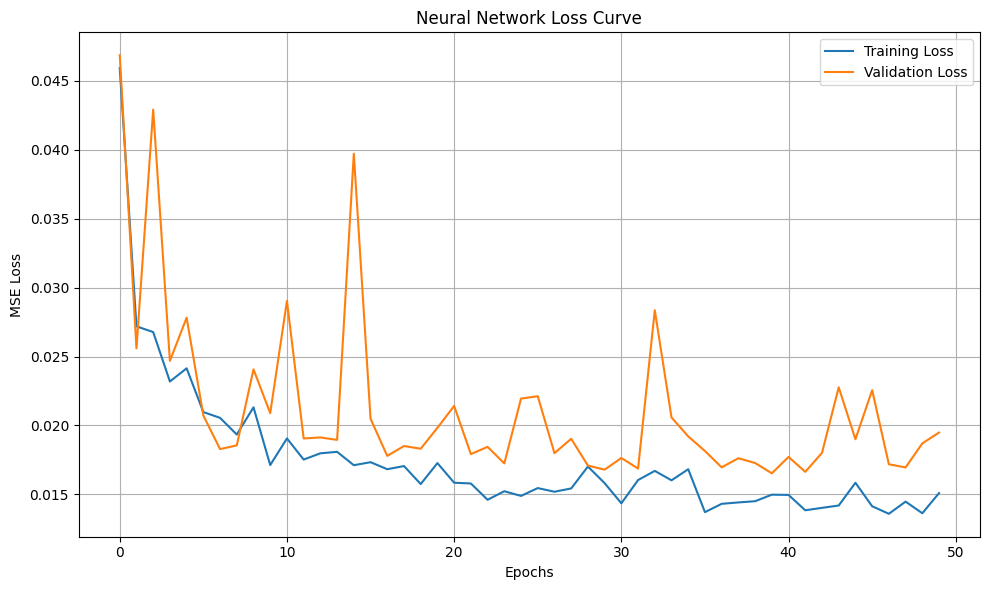

In [26]:
loss_curve(history_gru)

In [28]:
joblib.dump(model_gru, r'D:\Cloudly IO\Tesla-Forcasting-Project\notebook\saved_models\model_gru.pkl') #Save model

['D:\\Cloudly IO\\Tesla-Forcasting-Project\\notebook\\saved_models\\model_gru.pkl']